In [1]:
#ライブラリーをインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#データを読み込む
demog=pd.read_csv('demog.csv',index_col=0)
sales_visit=pd.read_csv('sales_visit.csv',index_col=0)

In [4]:
demog.head()

,id,exp10,avg_samp
1,1,0,0.721739
2,2,1,0.491304
3,3,0,0.339130
4,4,0,3.195652
5,5,1,0.347826


In [5]:
sales_visit.head()

,id,sales_num,visit_num,lagged_sales_num
1,1,3,1,4
2,1,12,1,3
3,1,3,1,12
4,1,6,2,3
5,1,5,1,6


In [6]:
#データを結合する
df=pd.merge(sales_visit,demog,on='id',how='left')

In [7]:
df.head()

,id,sales_num,visit_num,lagged_sales_num,exp10,avg_samp
0,1,3,1,4,0,0.721739
1,1,12,1,3,0,0.721739
2,1,3,1,12,0,0.721739
3,1,6,2,3,0,0.721739
4,1,5,1,6,0,0.721739


In [8]:
# データの整形
# idを0から始まる連続的な整数にエンコード
df['id'], _ = pd.factorize(df['id'])
id = df['id'].values
visit_num = df['visit_num'].values
lagged_sales_num = df['lagged_sales_num'].values
exp10 = df['exp10'].values
avg_samp = df['avg_samp'].values
sales_num = df['sales_num'].values

n_id = len(df['id'].unique())

# モデルの設定
with pm.Model() as model:
    # プライア分布の設定
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_id = pm.Normal('beta_id', mu=0, sd=10, shape=n_id)  # idごとの効果
    beta_visit_num = pm.Normal('beta_visit_num', mu=0, sd=10)
    beta_lagged_sales_num = pm.Normal('beta_lagged_sales_num', mu=0, sd=10)
    beta_exp10 = pm.Normal('beta_exp10', mu=0, sd=10)
    beta_avg_samp = pm.Normal('beta_avg_samp', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)

    # モデルの定義
    mu = alpha + beta_id[id] + beta_visit_num * visit_num + beta_lagged_sales_num * lagged_sales_num + beta_exp10 * exp10 + beta_avg_samp * avg_samp
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=sales_num)

    # サンプリング
    trace = pm.sample(draws=5000, tune=1000, target_accept=.9, cores=16, random_seed=42)

# 結果の確認
pm.summary(trace).round(2)


C:\Users\qwe26\AppData\Local\Temp\ipykernel_21988\91393627.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=5000, tune=1000, target_accept=.9, cores=16, random_seed=42)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sigma, beta_avg_samp, beta_exp10, beta_lagged_sales_num, beta_visit_num, beta_id, alpha]


Sampling 16 chains for 1_000 tune and 5_000 draw iterations (16_000 + 80_000 draws total) took 488 seconds.
The number of effective samples is smaller than 10% for some parameters.
c:\APP\anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.78,0.44,-0.05,1.59,0.02,0.01,747.0,1536.0,1.03
beta_id[0],-0.54,0.79,-2.02,0.94,0.01,0.01,3584.0,10623.0,1.00
beta_id[1],-5.24,1.03,-7.17,-3.31,0.02,0.02,1675.0,6063.0,1.01
beta_id[2],3.26,0.79,1.76,4.73,0.01,0.01,3415.0,10584.0,1.01
beta_id[3],-5.32,1.53,-8.11,-2.35,0.04,0.03,1349.0,2366.0,1.01
...,...,...,...,...,...,...,...,...,...
beta_visit_num,0.11,0.02,0.08,0.14,0.00,0.00,105131.0,68942.0,1.00
beta_lagged_sales_num,0.29,0.01,0.28,0.30,0.00,0.00,60323.0,61807.0,1.00
beta_exp10,5.78,0.83,4.22,7.36,0.03,0.02,814.0,2237.0,1.01
beta_avg_samp,2.76,0.49,1.84,3.68,0.02,0.01,1047.0,1730.0,1.02


In [10]:
result=pm.summary(trace).round(2)

c:\APP\anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [12]:
result.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.78,0.44,-0.05,1.59,0.02,0.01,747.0,1536.0,1.03
beta_id[0],-0.54,0.79,-2.02,0.94,0.01,0.01,3584.0,10623.0,1.00
beta_id[1],-5.24,1.03,-7.17,-3.31,0.02,0.02,1675.0,6063.0,1.01
beta_id[2],3.26,0.79,1.76,4.73,0.01,0.01,3415.0,10584.0,1.01
beta_id[3],-5.32,1.53,-8.11,-2.35,0.04,0.03,1349.0,2366.0,1.01


In [38]:
#beta_idの事後平均値をresult_idに格納
result_id = result.iloc[1:1001,0]


In [34]:
#beta_idの事後平均値の統計量を確認する
result_id.describe()

count    1000.000000
mean       -0.011690
std         3.446808
min       -10.030000
25%        -1.132500
50%        -0.300000
75%         0.930000
max        35.280000
Name: mean, dtype: float64

In [24]:
result_id = np.array(result_id)

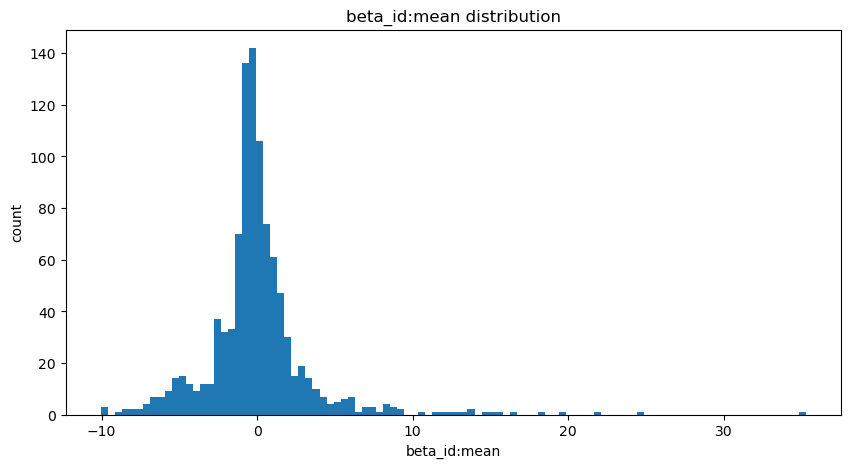

In [37]:
#result_idの分布を確認する
plt.figure(figsize=(10,5))
plt.hist(result_id,bins=100)
plt.xlabel('beta_id:mean')
plt.ylabel('count')
plt.title('beta_id:mean distribution')
plt.show()


In [15]:
#分析結果をcsvに出力する
result.to_csv('result.csv')